# **Self-Driving Project**

Download the test video from the below link:
https://bit.ly/test1mp4

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

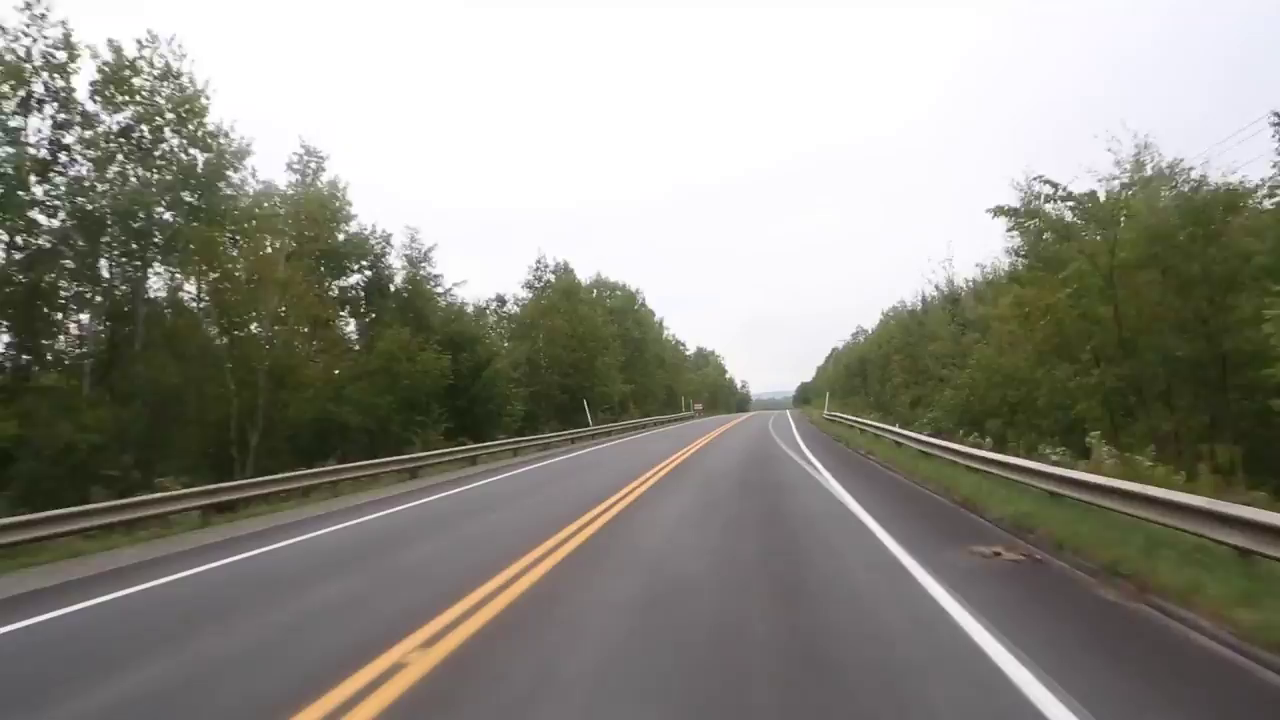

In [2]:
capture = cv2.VideoCapture('/content/test1.mp4')
ret, frame = capture.read()
cv2_imshow(frame)

### **Step1: Canny Edge Detection**

Canny edge detection is an image processing technique that extracts edges from images by detecting sudden changes in intensity. It involves several steps including smoothing with a Gaussian filter, finding gradients, non-maximum suppression, and edge tracking by hysteresis. The result is a binary image highlighting significant edges in the original image.

In [3]:
def canny(img):
  #convert the colored image to grayscale image
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  #blur the image so that it does detect the erroneous edges that we dont want
  kernel = 5
  blur = cv2.GaussianBlur(gray,(kernel,kernel),0)
  canny = cv2.Canny(blur,50,150)
  return canny

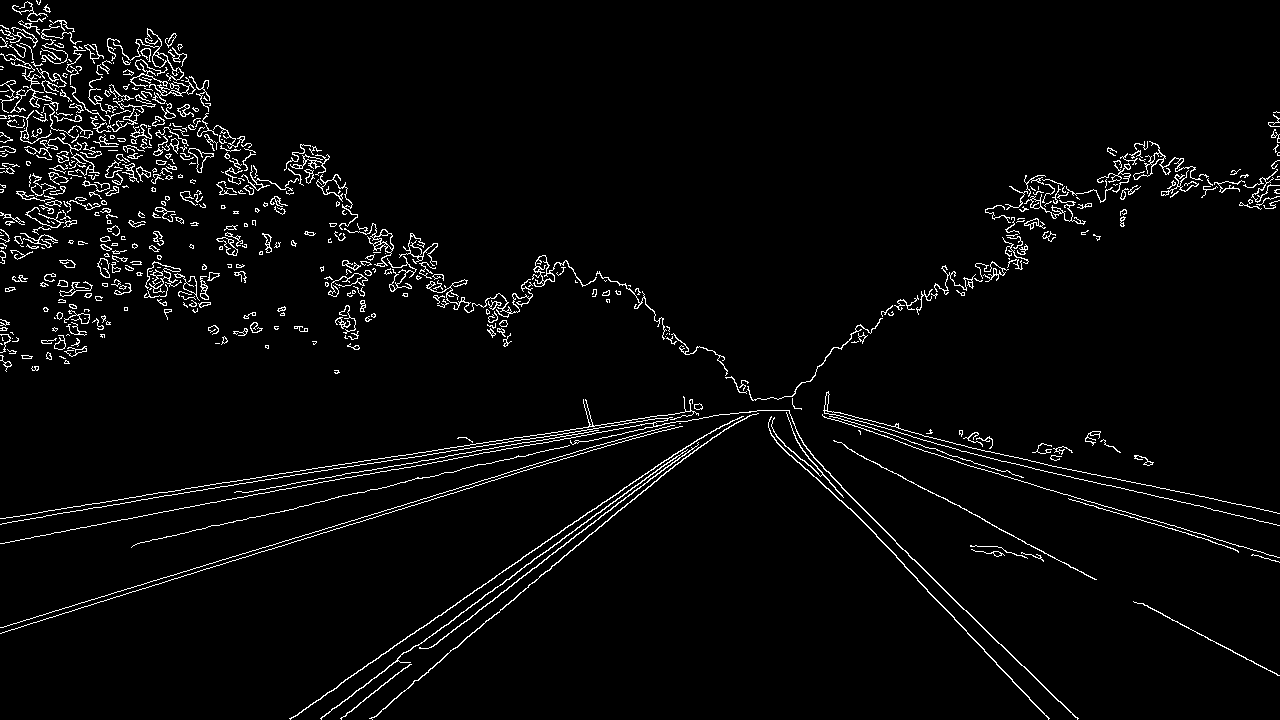

In [4]:
canny_output = canny(frame)
cv2_imshow(canny_output)

Creating the region interest that is just a triangle.

In [5]:
def region_of_interest(img):
  #height and width of the above image
  height = img.shape[0]
  width = img.shape[1]
  #mask everything else except the triangle we are interested in
  mask = np.zeros_like(img)
  triangle = np.array([[(200,height),(800,350),(1200,height),]], np.int32)
  #make the triangle white and everything except it black
  cv2.fillPoly(mask,triangle,255)
  masked_image = cv2.bitwise_and(img,mask)
  return masked_image

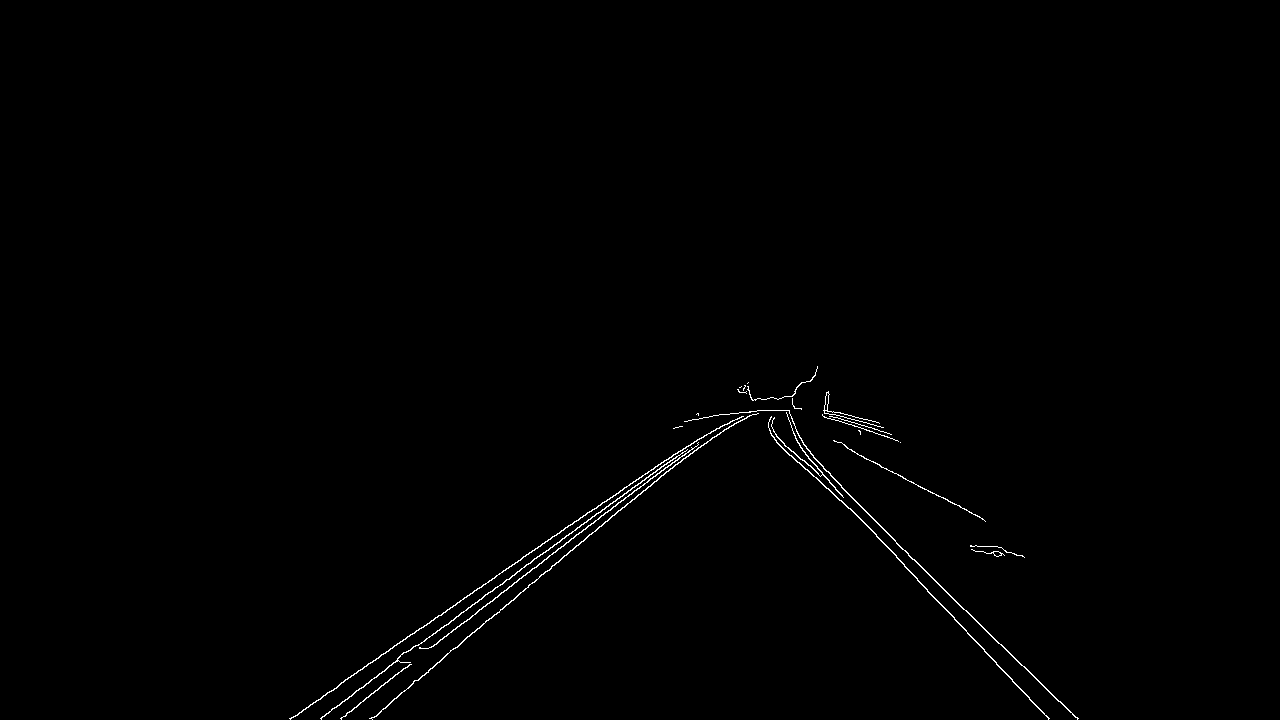

In [6]:
canny_output = canny(frame)
masked_output = region_of_interest(canny_output)
cv2_imshow(masked_output)

Maximum noise removed, but still some noise left adn will be removed using the **Hough transform**

######**Hough Transform**

The Hough transform is a technique used in computer vision to detect geometric shapes like lines, circles, or ellipses in images. It works by representing these shapes as mathematical equations in parameter space and finding peaks in an accumulator array, indicating the presence of those shapes in the image. This method is robust to noise and partial occlusion, making it widely used in tasks like object recognition and lane detection.

In [7]:
def houghLines(cropped_canny):
    return cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

In [8]:
def display_lines(img, lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 10)
    return line_image

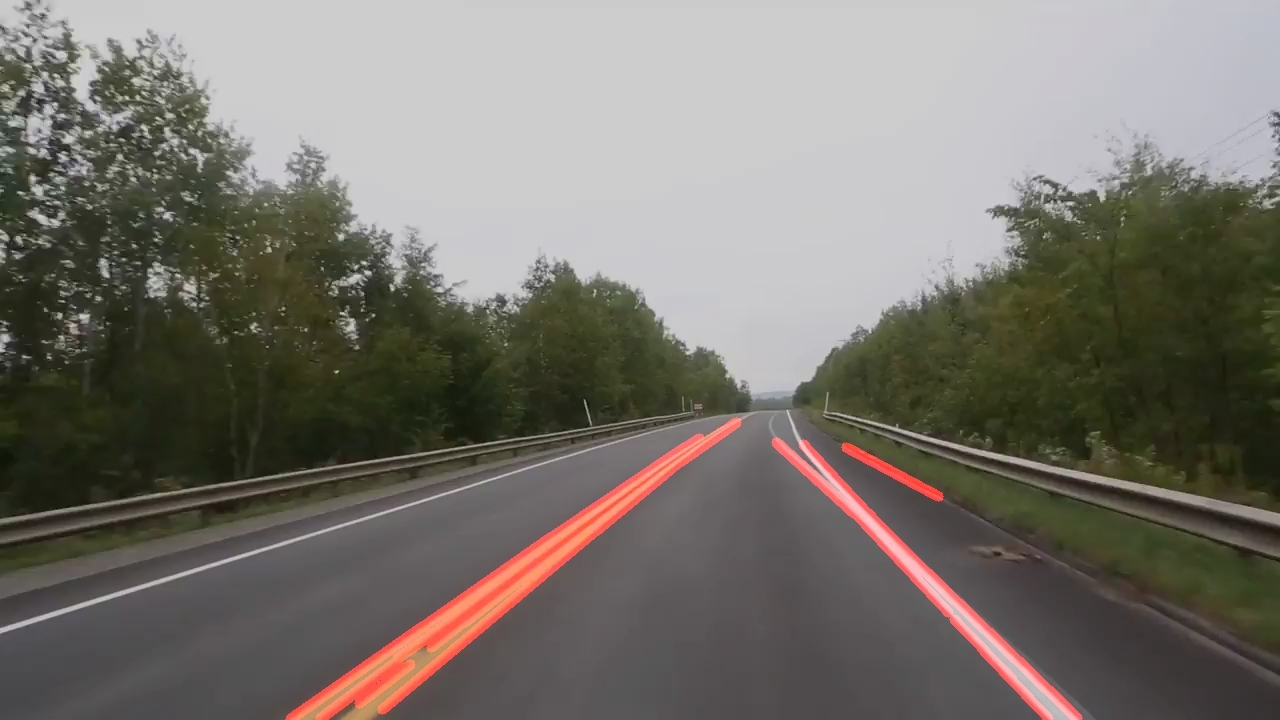

In [9]:
lines = houghLines(masked_output)
line_image = display_lines(frame,lines)
result = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
cv2_imshow(result)

Now we have a rough idea where the edges are, but there are some still noise. There are multiple lines too, we need to make them to single line. We will do that by taking average of the lines to the left and lines to the right.

In [10]:
def make_points(image, lineSI):
    slope, intercept = lineSI
    height = image.shape[0]
    y1 = int(height)
    y2 = int(y1*3.0/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]

In [11]:
def average_slope_intercept(image, lines):
    left_fit    = []
    right_fit   = []

    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            fit = np.polyfit((x1,x2), (y1,y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    left_fit_average  = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)

    left_line  = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    averaged_lines = [left_line, right_line]

    return averaged_lines

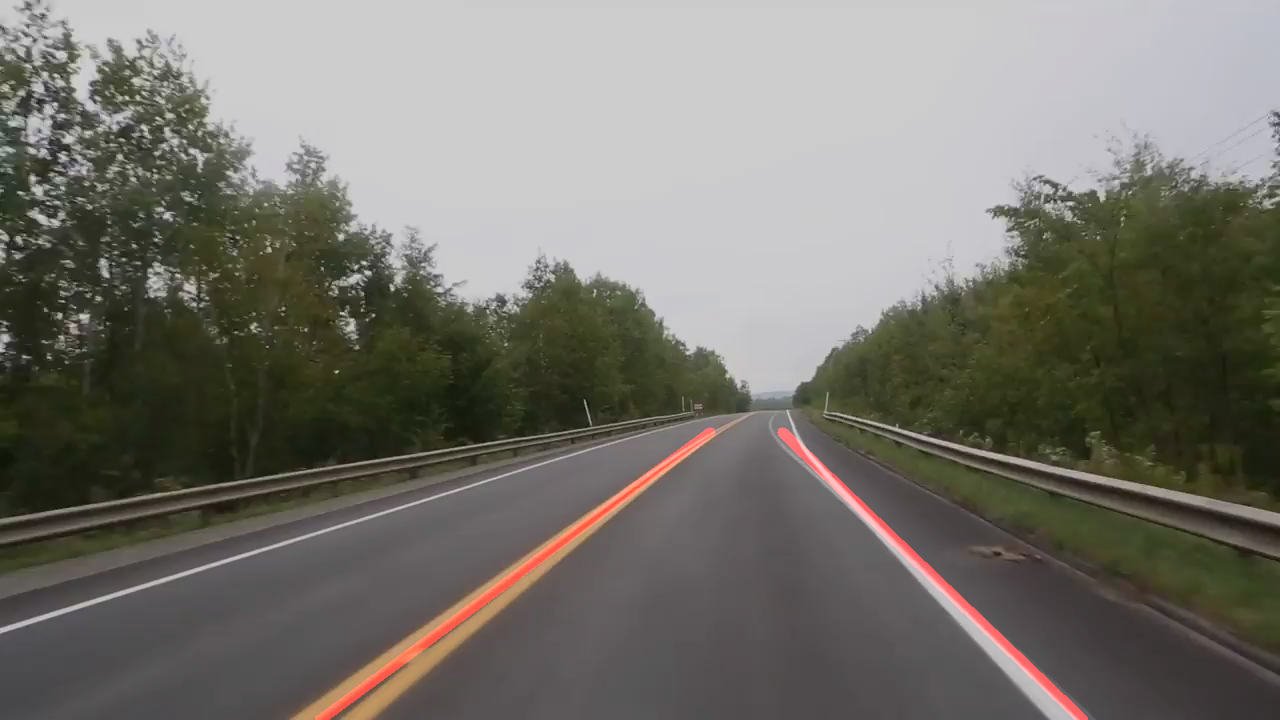

In [12]:
average_lines = average_slope_intercept(frame,lines)
line_image_avg = display_lines(frame,average_lines)
result_avg = cv2.addWeighted(frame, 0.8, line_image_avg, 1, 1)
cv2_imshow(result_avg)

In [ ]:
# capture = cv2.VideoCapture('/content/test1.mp4')

# while(capture.isOpened()):
#     ret, frame = capture.read()
#     if not ret:
#         break

#     canny_output = canny(frame)
#     masked_output = region_of_interest(canny_output)
#     lines = houghLines(masked_output)
#     average_lines = average_slope_intercept(frame, lines)

#     line_image_avg = display_lines(frame, average_lines)
#     result_avg = cv2.addWeighted(frame, 0.8, line_image_avg, 1, 1)
#     cv2_imshow(result_avg)

# capture.release()
# cv2.destroyAllWindows()

So, finally we have made basic line detection for self-drive cars.
But, this will be failed when there are curves and bends on the roads.
For that we need some Advanced Lane Detection.

### **BASIC LINE DETECTION DONE**

So, in Basic Line Detection, we used Canny Edge Detection, followed by The Hough transform adn finally averaging out the lines made by Hough transformation.
But, this fails when lines and roads are curvy and bended.


When a camera takes a picture of the surrounding, there is distortion that takes place, which makes it difficult for Basic Line Detection Algorithm to give correct results.
Therefore, **Advanced Line Detection** is important.

**Advanced Line Detection** refers to more sophisticated techniques used in computer vision and image processing to detect and track lane lines on roads more accurately and robustly. Traditional lane detection methods, such as the Canny edge detector and Hough transform, may struggle in challenging conditions such as varying lighting conditions, shadows, road markings, and occlusions.

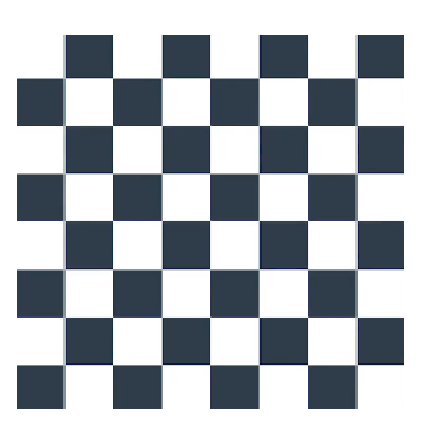

In [14]:
#number of boxes in x and y direction
nx = 7
ny = 7

img = cv2.imread('/content/chess.png')
cv2_imshow(img)

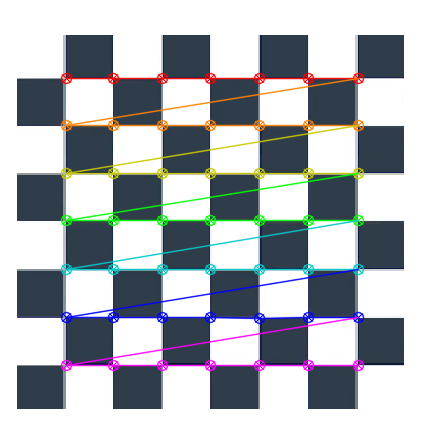

In [15]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
#draw the corners
if ret == True:
  cv2.drawChessboardCorners(img,(nx,ny), corners, ret)
  cv2_imshow(img)

This tells about the relative postion between the corners of the chess board. This will be used to reverse the distortion in the camera.

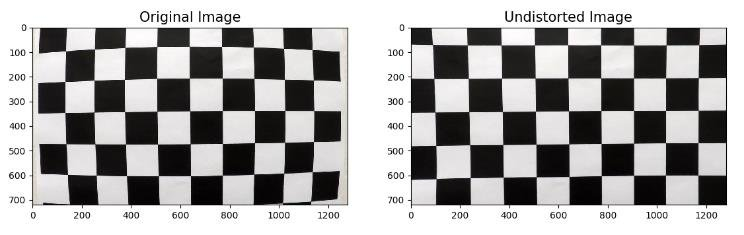

In [16]:
img1 = cv2.imread('/content/Distorted chess board.png')
cv2_imshow(img1)

We will take many distorted chess boards and then use them in our algorithm to finally give undistorted image of the chessboard.



In [1]:
#Disconnect and delete runtime
%ls

sample_data/


In [2]:
!git clone https://github.com/Dt-Pham/Advanced-Lane-Lines.git

Cloning into 'Advanced-Lane-Lines'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 104 (delta 3), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (104/104), 95.77 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
%cd Advanced-Lane-Lines/

/content/Advanced-Lane-Lines


In [14]:
import numpy as np
import cv2
import glob
#read all images in one go

#points in real-life
objpoints = []
#points assumed by opencv
imgpoints = []

images = glob.glob("{}/*".format("camera_cal"))
print(images)

['camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration3.jpg']


In [15]:
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6))
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

# Assuming all images have the same shape
img_shape = gray.shape[::-1]

# Calibrate camera
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

def undistort(distorted_image):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)


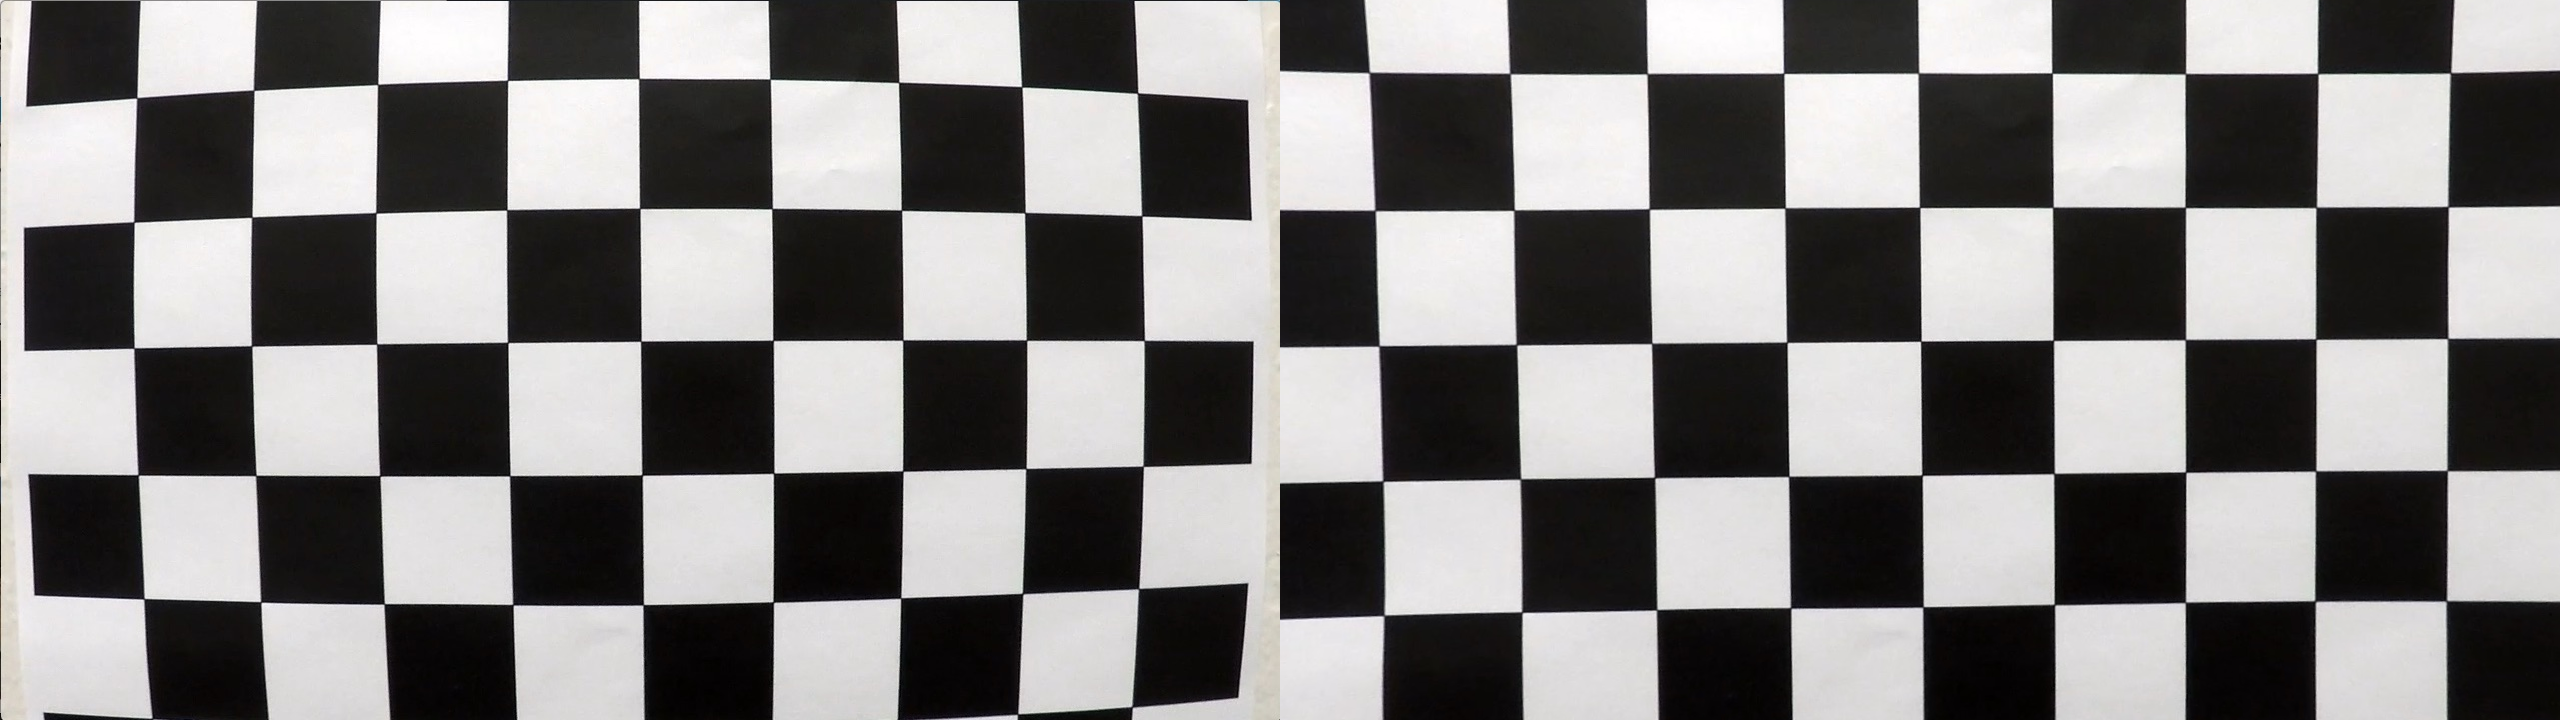

In [16]:
img = cv2.imread('/content/Advanced-Lane-Lines/camera_cal/calibration1.jpg')
output = undistort(img)

from google.colab.patches import cv2_imshow

# cv2_imshow(img)
# cv2_imshow(output)

display = np.hstack((img,output))
cv2_imshow(display)

Distorted image is now converted to Undistorted image.

### **PERCEPTION**

In [1]:
#Disconnect and delete runtime
!wget -O road.jpg https://raw.githubusercontent.com/Dt-Pham/Advanced-Lane-Lines/master/test_images/straight_lines2.jpg

--2024-05-02 19:42:50--  https://raw.githubusercontent.com/Dt-Pham/Advanced-Lane-Lines/master/test_images/straight_lines2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193098 (189K) [image/jpeg]
Saving to: ‘road.jpg’

road.jpg            100%[===================>] 188.57K  --.-KB/s    in 0.02s   

2024-05-02 19:42:51 (11.1 MB/s) - ‘road.jpg’ saved [193098/193098]



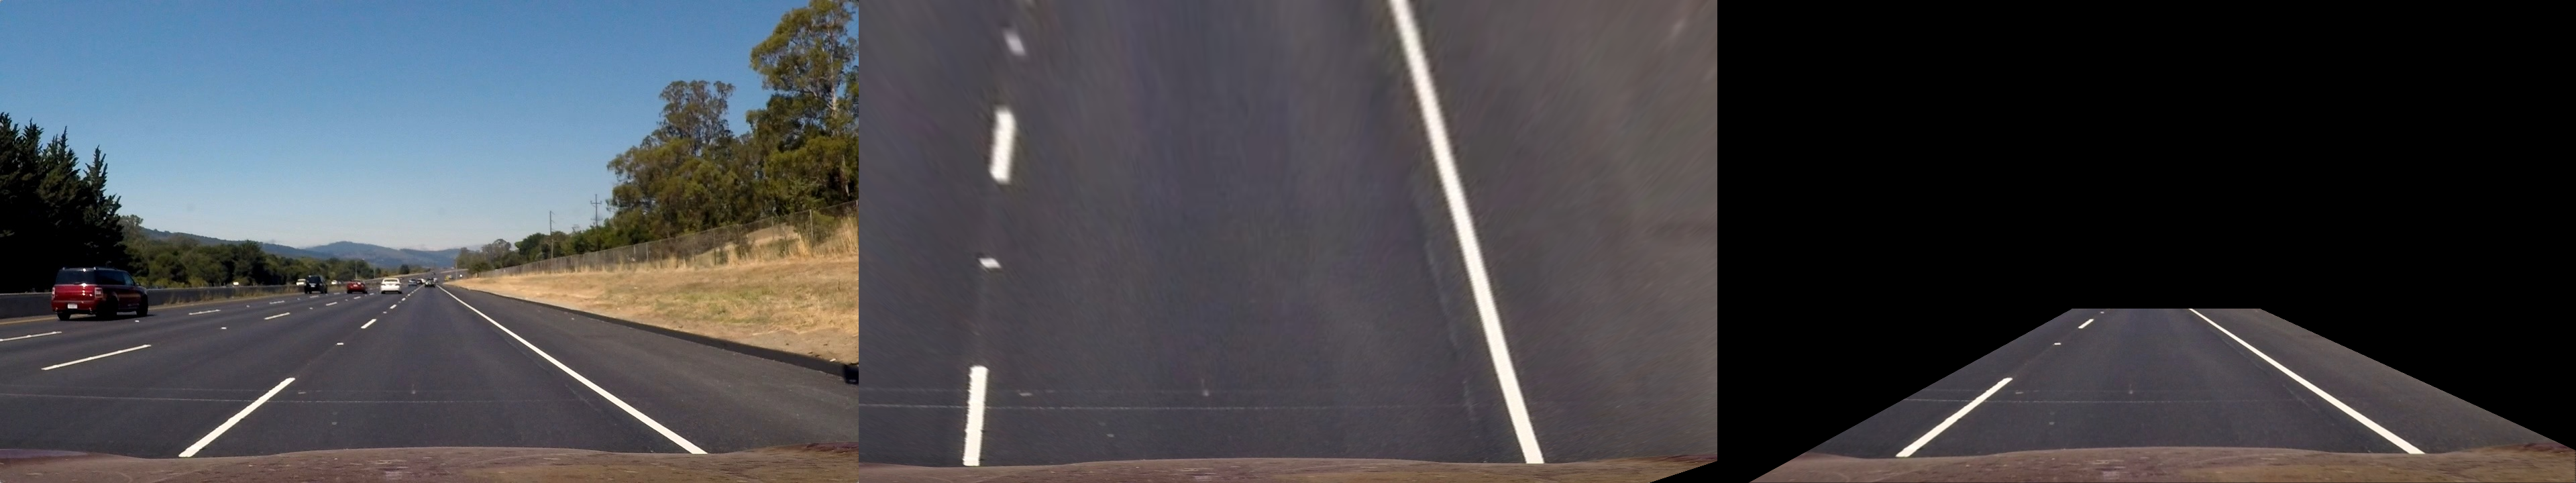

In [6]:
import cv2
import numpy as np

#trapezoidal road --> top view
src = np.float32([(550,460),(150,720),(1200,720),(770,460)])
dest = np.float32([(100,0),(100,720),(1100,720),(1100,0)])

M = cv2.getPerspectiveTransform(src,dest)
M_inv = cv2.getPerspectiveTransform(dest,src)

def front_to_top(img):
  size = (1280,720)
  return cv2.warpPerspective(img,M,size,flags=cv2.INTER_LINEAR)

image = cv2.imread("road.jpg")
output_top = front_to_top(image)

from google.colab.patches import cv2_imshow
# cv2_imshow(image)
# cv2_imshow(output)

def top_to_front(img):
  size = (1280,720)
  return cv2.warpPerspective(img,M_inv,size,flags=cv2.INTER_LINEAR)

output_front = top_to_front(output_top)

final = np.hstack((image,output_top,output_front))
cv2_imshow(final)

See the 3rd image is only the image (trapezoid) that we are interested in.